# Homework: Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

This homework requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- homework_modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)
- homework_differentiation.ipynb

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [3]:
# (re-)load layers
%run homework_modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

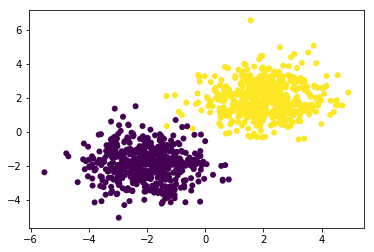

In [4]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [13]:
#net = Sequential()
#net.add(Linear(2, 2))
#net.add(LogSoftMax())

#print(net)

criterion = ClassNLLCriterion()

# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [14]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [15]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

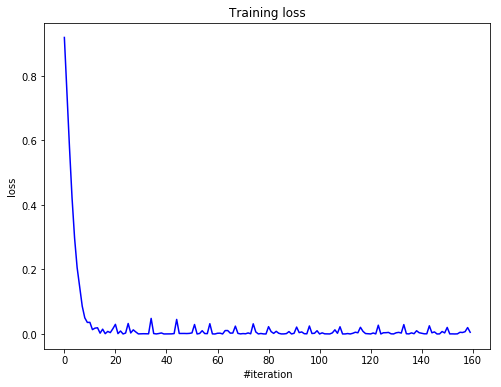

Current loss: 0.005256


In [16]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [17]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [88]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import tqdm
from sklearn.metrics import accuracy_score

In [40]:
oh_encoder.fit(y_train.reshape((-1, 1)))

y_train_ohe = oh_encoder.transform(y_train.reshape(-1, 1))
y_val_ohe = oh_encoder.transform(y_val.reshape((-1, 1)))
y_test_ohe = oh_encoder.transform(y_test.reshape((-1, 1)))

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when tbhe lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [118]:
net = Sequential()
net.add(Flatten())
net.add(Linear(28 * 28, 50))
#net.add(BatchNormalization())
net.add(ReLU())
#net.add(Dropout(p=0.5))
net.add(Linear(50, 10))
#net.add(BatchNormalization())
net.add(LogSoftMax())

In [119]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

criterion = ClassNLLCriterion()

# Looping params
n_epoch = 20
batch_size = 1024

In [120]:
for i in range(n_epoch):
    print("Epoch {} started...".format(i))
    
    net.train()
    epoch_losses = []
    for x_batch, y_batch in (get_batches((X_train, y_train_ohe), batch_size)):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        epoch_losses.append(loss)
    
    print("Epoch {} mean loss: {:.3f}".format(i, np.mean(epoch_losses)))
    
    net.evaluate()
    y_true, y_pred = [], []
    for x_batch, y_batch in (get_batches((X_val, y_val), batch_size)):
        batch_output = net.forward(x_batch)
        y_pred += list(np.argmax(batch_output, axis=1))
        y_true += list(y_batch)
        
    print("Validation {} epoch accuracy: {:.3f}".format(i, accuracy_score(y_true, y_pred)))

Epoch 0 started...
Epoch 0 mean loss: 0.932
Validation 0 epoch accuracy: 0.899
Epoch 1 started...
Epoch 1 mean loss: 0.329
Validation 1 epoch accuracy: 0.923
Epoch 2 started...
Epoch 2 mean loss: 0.279
Validation 2 epoch accuracy: 0.931
Epoch 3 started...
Epoch 3 mean loss: 0.240
Validation 3 epoch accuracy: 0.939
Epoch 4 started...
Epoch 4 mean loss: 0.211
Validation 4 epoch accuracy: 0.944
Epoch 5 started...
Epoch 5 mean loss: 0.188
Validation 5 epoch accuracy: 0.946
Epoch 6 started...
Epoch 6 mean loss: 0.172
Validation 6 epoch accuracy: 0.953
Epoch 7 started...
Epoch 7 mean loss: 0.155
Validation 7 epoch accuracy: 0.955
Epoch 8 started...
Epoch 8 mean loss: 0.142
Validation 8 epoch accuracy: 0.958
Epoch 9 started...
Epoch 9 mean loss: 0.132
Validation 9 epoch accuracy: 0.960
Epoch 10 started...
Epoch 10 mean loss: 0.122
Validation 10 epoch accuracy: 0.962
Epoch 11 started...
Epoch 11 mean loss: 0.114
Validation 11 epoch accuracy: 0.963
Epoch 12 started...
Epoch 12 mean loss: 0.107


Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

I'll try different networks with `BatchNormaliation` layers after `Linear` and without. At this toy problem result were nearest the same. Even with `BatchNormalization` layers i have `-0.005` worse accuracy after `20` epochs.

`Dropout` layer doesn't help a lot too. Time of training increased, and validation accuracy were lower.

In my case the best model is simple model without `Dropout` and `BatchNormalization` layers with `ReLU` non-linearity.

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [121]:
net.evaluate()

y_true, y_pred = [], []
for x_batch, y_batch in (get_batches((X_test, y_test), batch_size)):
    batch_output = net.forward(x_batch)
    
    y_pred += list(np.argmax(batch_output, axis=1))
    y_true += list(y_batch)

print("Test accuracy: {:.3f}".format(accuracy_score(y_true, y_pred)))

Test accuracy: 0.970
